Aluno: Domingos Jordão Dal Magro Silva<br>
RGA: 201811722001<br>
Materia: Inteligencia Artifical<br>
Prof: Dr. Rafael Teixeira<br>
Atividade Avaliativa 2

In [2]:
# Importando libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Carrega o dataframe que vamos analisar
df = pd.read_csv("/content/drive/MyDrive/INFLUD21-28-02-2022.csv", sep=";", usecols=["NU_IDADE_N","CS_SEXO","FATOR_RISC","ANTIVIRAL","VACINA","DISPNEIA","RENAL","DIABETES","HEPATICA","VACINA_COV","CLASSI_FIN","SATURACAO","PNEUMOPATI","IMUNODEPRE","EVOLUCAO"])

# Delimitei as colunas que vao ser utilizadas para reduzir o uso de memoria

# Colunas Utilizadas
# NU_IDADE_N == idade
# CS_SEXO    == sexo
# FATOR_RISC == pessoa possui fator de risco
# ANTIVIRAL  == pessoa usou antiviral
# VACINA     == vacina de gripe
# DISPNEIA   == falta de ar
# RENAL      == problemas nos rins
# DIABETES   == diabetes
# HEPATICA   == problemas no figado
# VACINA_COV == tomou vacina para covid
# CLASSI_FIN == diagnostico final (covid ou nao)
# SATURACAO  == saturacao menor do que 95%
# PNEUMOPATI == problemas respiratorios
# IMUNODEPRE == imunodeficiencia
# EVOLUCAO   == obito ou nao obito

In [17]:
# Mostra algumas linhas das informacoes que serao utilizadas
df.head()

,CS_SEXO,NU_IDADE_N,DISPNEIA,SATURACAO,FATOR_RISC,HEPATICA,DIABETES,PNEUMOPATI,IMUNODEPRE,RENAL,VACINA,ANTIVIRAL,CLASSI_FIN,EVOLUCAO,VACINA_COV
0,M,67,2.0,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,NaN
1,M,18,1.0,2.0,2,NaN,NaN,NaN,NaN,NaN,2.0,2.0,5.0,1.0,NaN
2,F,90,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,2.0,2.0,5.0,2.0,NaN
3,F,83,2.0,2.0,1,2.0,2.0,2.0,2.0,2.0,9.0,9.0,4.0,1.0,NaN
4,F,72,1.0,1.0,1,2.0,2.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,NaN


In [18]:
#limpa alguns dados que nao sao relevantes para a analise

#troca 9 e NaN por 0           
df = df.replace(9.0,0.0)   
df = df.fillna(0.0)

#retira linhas
df = df.drop(df[df["NU_IDADE_N"] > 120 ].index)  #retira linhas onde pessoa tem mais de 120 anos
df = df.drop(df[df["EVOLUCAO"] > 2.0 ].index)    #retira linhas onde evolucao é ignoarada ou morte por outros motivos
df = df.drop(df[df["CLASSI_FIN"] != 5.0].index)  #retira linhas onde classificacao final é indefinida

In [19]:
#modifica as informacoes do dataframe para valores binarios (0 ou 1)
def data2bin(df, data):           #recebe o dataframe e o dado a ser setado como 1
    tempDFArray = []              #cria um vetor temporario para armazenar os dados
    for dfData in df:             #itera sobre todo o dataframe convertendo os dados
        if dfData == data:        #se o dado do df for igual ao informado
            tempDFArray.append(1) #seta 1
        else:                     #senao
            tempDFArray.append(0) #seta 0
    return tempDFArray            #retorna o vetor com os dados convertidos

def age2bin(df, data):            #recebe o dataframe e o dado a ser setado como 1
    tempDFArray = []              #cria um vetor temporario para armazenar os dados
    for dfData in df:             #itera sobre todo o dataframe convertendo os dados
        if dfData > data:         #se o dado do df for igual ao informado
            tempDFArray.append(1) #seta 1
        else:                     #senao
            tempDFArray.append(0) #seta 0
    return tempDFArray            #retorna o vetor com os dados convertidos

In [20]:
df["EVOLUCAO"] = data2bin(df["EVOLUCAO"], 1)       # 0 - obito | 1 - nao obito
df["FATOR_RISC"] = data2bin(df["FATOR_RISC"], "S") # 0 - nao   | 1 - sim
df["CS_SEXO"] = data2bin(df["CS_SEXO"], "M")       # 0 - femin | 1 - masc
df["ANTIVIRAL"] = data2bin(df["ANTIVIRAL"], 1)     # 0 - nao   | 1 - sim
df["VACINA"] = data2bin(df["VACINA"], 1)           # 0 - nao   | 1 - sim
df["DISPNEIA"] = data2bin(df["DISPNEIA"], 1)       # 0 - nao   | 1 - sim
df["RENAL"] = data2bin(df["RENAL"], 1)             # 0 - nao   | 1 - sim
df["DIABETES"] = data2bin(df["DIABETES"], 1)       # 0 - nao   | 1 - sim
df["HEPATICA"] = data2bin(df["HEPATICA"], 1)       # 0 - nao   | 1 - sim
df["VACINA_COV"] = data2bin(df["VACINA_COV"], 1)   # 0 - nao   | 1 - sim
df["CLASSI_FIN"] = data2bin(df["CLASSI_FIN"], 5)   # 0 - nao   | 1 - covid
df["SATURACAO"] = data2bin(df["SATURACAO"], 1)     # 0 - nao   | 1 - sim
df["PNEUMOPATI"] = data2bin(df["PNEUMOPATI"], 1)   # 0 - nao   | 1 - sim
#df["NU_IDADE_N"] = age2bin(df["NU_IDADE_N"], 35)
df["IMUNODEPRE"] = data2bin(df["IMUNODEPRE"], 1)   # 0 - nao   | 1 - sim

In [21]:
#Exibe alguns dados processados
df.shape
df.head()

,CS_SEXO,NU_IDADE_N,DISPNEIA,SATURACAO,FATOR_RISC,HEPATICA,DIABETES,PNEUMOPATI,IMUNODEPRE,RENAL,VACINA,ANTIVIRAL,CLASSI_FIN,EVOLUCAO,VACINA_COV
1,1,18,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,90,1,1,0,0,0,0,0,0,0,0,1,0,0
4,0,72,1,1,0,0,0,1,1,0,0,0,1,1,0
5,0,64,0,0,0,0,1,0,0,0,1,1,1,1,0
6,0,68,0,0,0,0,0,0,0,0,0,0,1,1,0


In [22]:
# Processa os dados do dataframe para criar subsets de treino e teste
#dataColumns = ["NU_IDADE_N","CS_SEXO","FATOR_RISC","ANTIVIRAL","VACINA","DISPNEIA","RENAL","DIABETES","HEPATICA","VACINA_COV","CLASSI_FIN","SATURACAO","PNEUMOPATI","IMUNODEPRE"]
dataColumns = ["NU_IDADE_N","CS_SEXO","FATOR_RISC","ANTIVIRAL","VACINA","DISPNEIA","RENAL","DIABETES","HEPATICA","VACINA_COV","CLASSI_FIN","SATURACAO","PNEUMOPATI","IMUNODEPRE"]
X = df[dataColumns]
y = df.EVOLUCAO #target

xTraining, testX, yTraining, testY = train_test_split(X, y, test_size=0.50, random_state=0)

In [23]:
# Treinando o classificador usando a coluna EVOLUCAO como alvo
#classify = LogisticRegression(max_iter=200)
classify = GradientBoostingClassifier()

classify.fit(xTraining, yTraining)
yPrediction = classify.predict(testX)

classify.score(testX, testY)

accuracy = metrics.accuracy_score(testY, yPrediction) 
print("Accuracy =", accuracy*100,"%")

#gradientBoosting = 65.56%
#logisticRegression = 65.29%

Accuracy = 65.56006275099128 %


In [24]:
# Geracao da matriz confusao a partir das previsoes e testes
confusion = metrics.confusion_matrix(testY, yPrediction)
print("Resultado Matriz Confusao:\n",confusion)

Resultado Matriz Confusao:
 [[ 94616 139993]
 [ 63515 292783]]


Text(0.5, 1.1, 'Matriz Confusao')

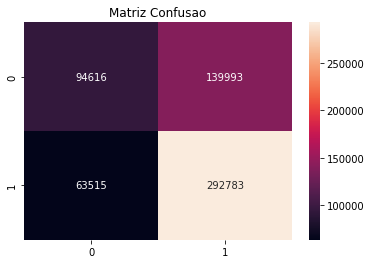

In [25]:
className=[0,1] 

fig, ax = plt.subplots()
tick_marks = np.arange(len(className))
plt.xticks(tick_marks, className)
plt.yticks(tick_marks, className)

sns.heatmap(pd.DataFrame(confusion),annot=True,fmt='g')

plt.title('Matriz Confusao', y=1.1)